### 1 Загрузите данные ####

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score


sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)


file_path = 'База.csv'
try:
    df_raw = pd.read_csv(file_path, sep=';')
    print(f"Данные успешно загружены. Форма: {df_raw.shape}")
except FileNotFoundError:
    print(f"нет файла в пути '{file_path}'.")

Данные успешно загружены. Форма: (5519, 21)


### 2 Предварительная фильтрация. ###

In [1816]:

df_filtered = df_raw[df_raw['ВидПомещения'].str.strip() == 'жилые помещения'].copy()
final_statuses = ['Продана', 'Свободна']
df_final = df_filtered[df_filtered['СледующийСтатус'].isin(final_statuses)].copy()

df_final['target'] = df_final['СледующийСтатус'].map({'Продана': 1, 'Свободна': 0})
df_final.drop(['УИД_Брони', 'ВидПомещения', 'СледующийСтатус'], axis=1, inplace=True)
print(f"Данные отфильтрованы. Размер для обработки: {df_final.shape}")

Данные отфильтрованы. Размер для обработки: (3944, 19)


### 3 Проверьте тип данных и преобразуйте все данные к числовому типу.

In [1817]:


df_processed = df_final.copy()

numeric_cols = [
    'ПродаваемаяПлощадь', 'Этаж', 'СтоимостьНаДатуБрони', 
    'СкидкаНаКвартиру', 'ФактическаяСтоимостьПомещения', 'Тип'
]
for col in numeric_cols:
    if df_processed[col].dtype == 'object':
        if col == 'Тип':
            df_processed[col] = df_processed[col].str.replace('к', '', regex=False)
        df_processed[col] = df_processed[col].str.replace(',', '.', regex=False)
    
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
print("Числовые столбцы преобразованы.")


binary_cols_map = {
    'ВременнаяБронь': {'да': 1, 'нет': 0},
    'СделкаАН': {'да': 1, 'нет': 0},
    'ИнвестиционныйПродукт': {'да': 1, 'нет': 0},
    'Привилегия': {'да': 1, 'нет': 0}
}
for col, mapping in binary_cols_map.items():
    df_processed[col] = df_processed[col].str.lower().map(mapping)

df_processed['ИсточникБрони'] = df_processed['ИсточникБрони'].map({'ручная': 0, 'МП': 1})

df_processed['ТипСтоимости'] = df_processed['ТипСтоимости'].str.contains('100%', na=False).astype(int)
df_processed['ВариантОплаты'] = df_processed['ВариантОплаты'].str.contains('Единовременная', na=False).astype(int)
print("Бинарные признаки закодированы.")


df_processed = pd.get_dummies(df_processed, columns=['Город', 'Статус лида (из CRM)'], drop_first=True, dtype=int)
print("one-hot признаки закодированы.")


df_processed.drop(['ДатаБрони', 'ВремяБрони', 'ВариантОплатыДоп'], axis=1, inplace=True, errors='ignore')
display(df_processed)



Числовые столбцы преобразованы.
Бинарные признаки закодированы.
one-hot признаки закодированы.


,ИсточникБрони,ВременнаяБронь,Тип,ПродаваемаяПлощадь,Этаж,СтоимостьНаДатуБрони,ТипСтоимости,ВариантОплаты,СкидкаНаКвартиру,ФактическаяСтоимостьПомещения,...,Город_Набережные Челны,Город_Пермь,Город_Сочи,Город_Тверь,Город_Тюмень,Город_Уфа,Город_Хабаровск,Город_Ярославль,Статус лида (из CRM)_P,Статус лида (из CRM)_S
0,0,1,2.5,72.0,3.0,4296100.0,1,1,NaN,4296100.0,...,0,0,0,0,0,0,0,1,0,1
1,0,1,3.5,79.8,2.0,5279600.0,1,1,NaN,5279600.0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,2.5,65.4,18.0,4201400.0,1,1,NaN,4201400.0,...,0,0,0,0,0,0,0,1,0,1
3,0,1,2.5,61.6,12.0,5414500.0,1,1,NaN,5414500.0,...,0,0,0,0,1,0,0,0,0,1
4,0,1,2.5,65.4,18.0,4201400.0,1,1,NaN,4201400.0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5507,1,0,2.0,46.5,1.0,3494100.0,1,1,NaN,3494100.0,...,1,0,0,0,0,0,0,0,0,0
5512,1,1,3.0,86.3,10.0,7557600.0,1,1,NaN,7557600.0,...,1,0,0,0,0,0,0,0,0,0
5514,0,0,NaN,30.0,14.0,2373200.0,1,1,-94928.0,2468128.0,...,1,0,0,0,0,0,0,0,0,0
5516,1,1,1.5,46.3,9.0,4499000.0,1,1,NaN,4499000.0,...,1,0,0,0,0,0,0,0,0,0


### 4 Проверьте, есть ли по каким-либо признакам отсутствующие данные.

In [1818]:
if 'СкидкаНаКвартиру' in df_processed.columns:
    df_processed['СкидкаНаКвартиру'] = df_processed['СкидкаНаКвартиру'].fillna(0)
    print(f"Столбец 'СкидкаНаКвартиру': пропуски заменены на 0")

for col in df_processed.columns:
    if col == 'СкидкаНаКвартиру':
        continue  # Уже обработали

    if df_processed[col].isnull().any():
        print(f"В столбце {col} {df_processed[col].isnull().sum()} пропусков")
        if pd.api.types.is_numeric_dtype(df_processed[col]):
            median_val = df_processed[col].median()
            df_processed[col] = df_processed[col].fillna(median_val)
            print(f"В столбце '{col}': пропуски заменены медианой ({median_val:.2f})")

if df_processed.isnull().sum().sum() == 0:
    print(f"\nОчистка завершена успешно. Финальный размер: {df_processed.shape}")
else:
    print("Ого, вот это абоба")

Столбец 'СкидкаНаКвартиру': пропуски заменены на 0
В столбце Тип 203 пропусков
В столбце 'Тип': пропуски заменены медианой (2.00)
В столбце ПродаваемаяПлощадь 44 пропусков
В столбце 'ПродаваемаяПлощадь': пропуски заменены медианой (60.50)

Очистка завершена успешно. Финальный размер: (3944, 24)


Остальных пропусков не найдено, поле «ВариантОплатыДоп» удален.

### 5 Дополнение данных.

In [1819]:

df_processed['ЦенаЗаМетр'] = df_processed['ФактическаяСтоимостьПомещения'] / (df_processed['ПродаваемаяПлощадь'])
initial_price = df_processed['СтоимостьНаДатуБрони'] + df_processed['СкидкаНаКвартиру']
df_processed['СкидкаПроцент'] = (df_processed['СкидкаНаКвартиру'] / initial_price) * 100
print("Созданы новые признаки.")



Созданы новые признаки.


### 6 Выполните нормализацию. и 8 Сформируйте список факторных признаков и целевой признак.

In [1820]:
# 8 задание
y = df_processed['target']
X = df_processed.drop('target', axis=1)
# 6 задание
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled['СкидкаНаКвартиру'] = (X_scaled['СкидкаНаКвартиру'] - 0.5)


### 7 Проверьте датасет на сбалансированность

In [1821]:
print(f"Баланс классов: \n{y.value_counts(normalize=True)}")

Баланс классов: 
target
0    0.710953
1    0.289047
Name: proportion, dtype: float64


Датасет несбалансирован. 

Сбалансированный: 45-55% (максимальная разница 10%)

Умеренный дисбаланс: 60-40% (разница до 20%)

Сильный дисбаланс: 70-30% (разница > 20%) ← ВАШ СЛУЧАЙ

Критический дисбаланс: 90-10% (разница > 40%)

### 9 Выполните разбиение датасета на обучающую и тестовую выборки.

In [1822]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=1000000000, stratify=y
)
print(f"Данные готовы. Train: {X_train.shape}, Test: {X_test.shape}")

Данные готовы. Train: (2760, 25), Test: (1184, 25)


### 10 алгоритм классификации KNN

In [1823]:
def evaluate_model(model, model_name):
    print(f"\n--- Оценка модели: {model_name} ---")
    
    model.fit(X_train, y_train)
    
    # 12 Получите векторы прогнозных значений
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # 13 Посчитайте показатели качества:
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    print(f"  Обучающая выборка: Precision={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}")
    print(f"  Тестовая выборка:  Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1={test_f1:.4f}")
    
    return {
        'model': model_name,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }

knn = KNeighborsClassifier()
knn_results = evaluate_model(knn, "K-Nearest Neighbors (KNN)")


--- Оценка модели: K-Nearest Neighbors (KNN) ---
  Обучающая выборка: Precision=0.8540, Recall=0.7769, F1=0.8136
  Тестовая выборка:  Precision=0.7637, Recall=0.6520, F1=0.7035


### 11 Алгоритм классификации на основе деревьев решений (DecisionTreeClassifier).

In [1824]:
tree = DecisionTreeClassifier(random_state=42)
tree_results = evaluate_model(tree, "Decision Tree")


--- Оценка модели: Decision Tree ---
  Обучающая выборка: Precision=1.0000, Recall=0.9825, F1=0.9912
  Тестовая выборка:  Precision=0.8097, Recall=0.7836, F1=0.7964


### 14.Сделайте вывод

In [1825]:
print("\n--- Итоговое сравнение моделей ---")
results_df = pd.DataFrame([knn_results, tree_results]).sort_values('test_f1', ascending=False)
display(results_df)


--- Итоговое сравнение моделей ---


,model,train_precision,train_recall,train_f1,test_precision,test_recall,test_f1
1,Decision Tree,1.000000,0.982456,0.991150,0.809668,0.783626,0.796434
0,K-Nearest Neighbors (KNN),0.853994,0.776942,0.813648,0.763699,0.652047,0.703470


# Дополнительные задания

### 15 (1 балл) Постройте boxplot («ящик с усами») для всех числовых признаков

--- Визуализация выбросов до удаления ---
Медиана стоимости бронирования: 4,951,150 руб.


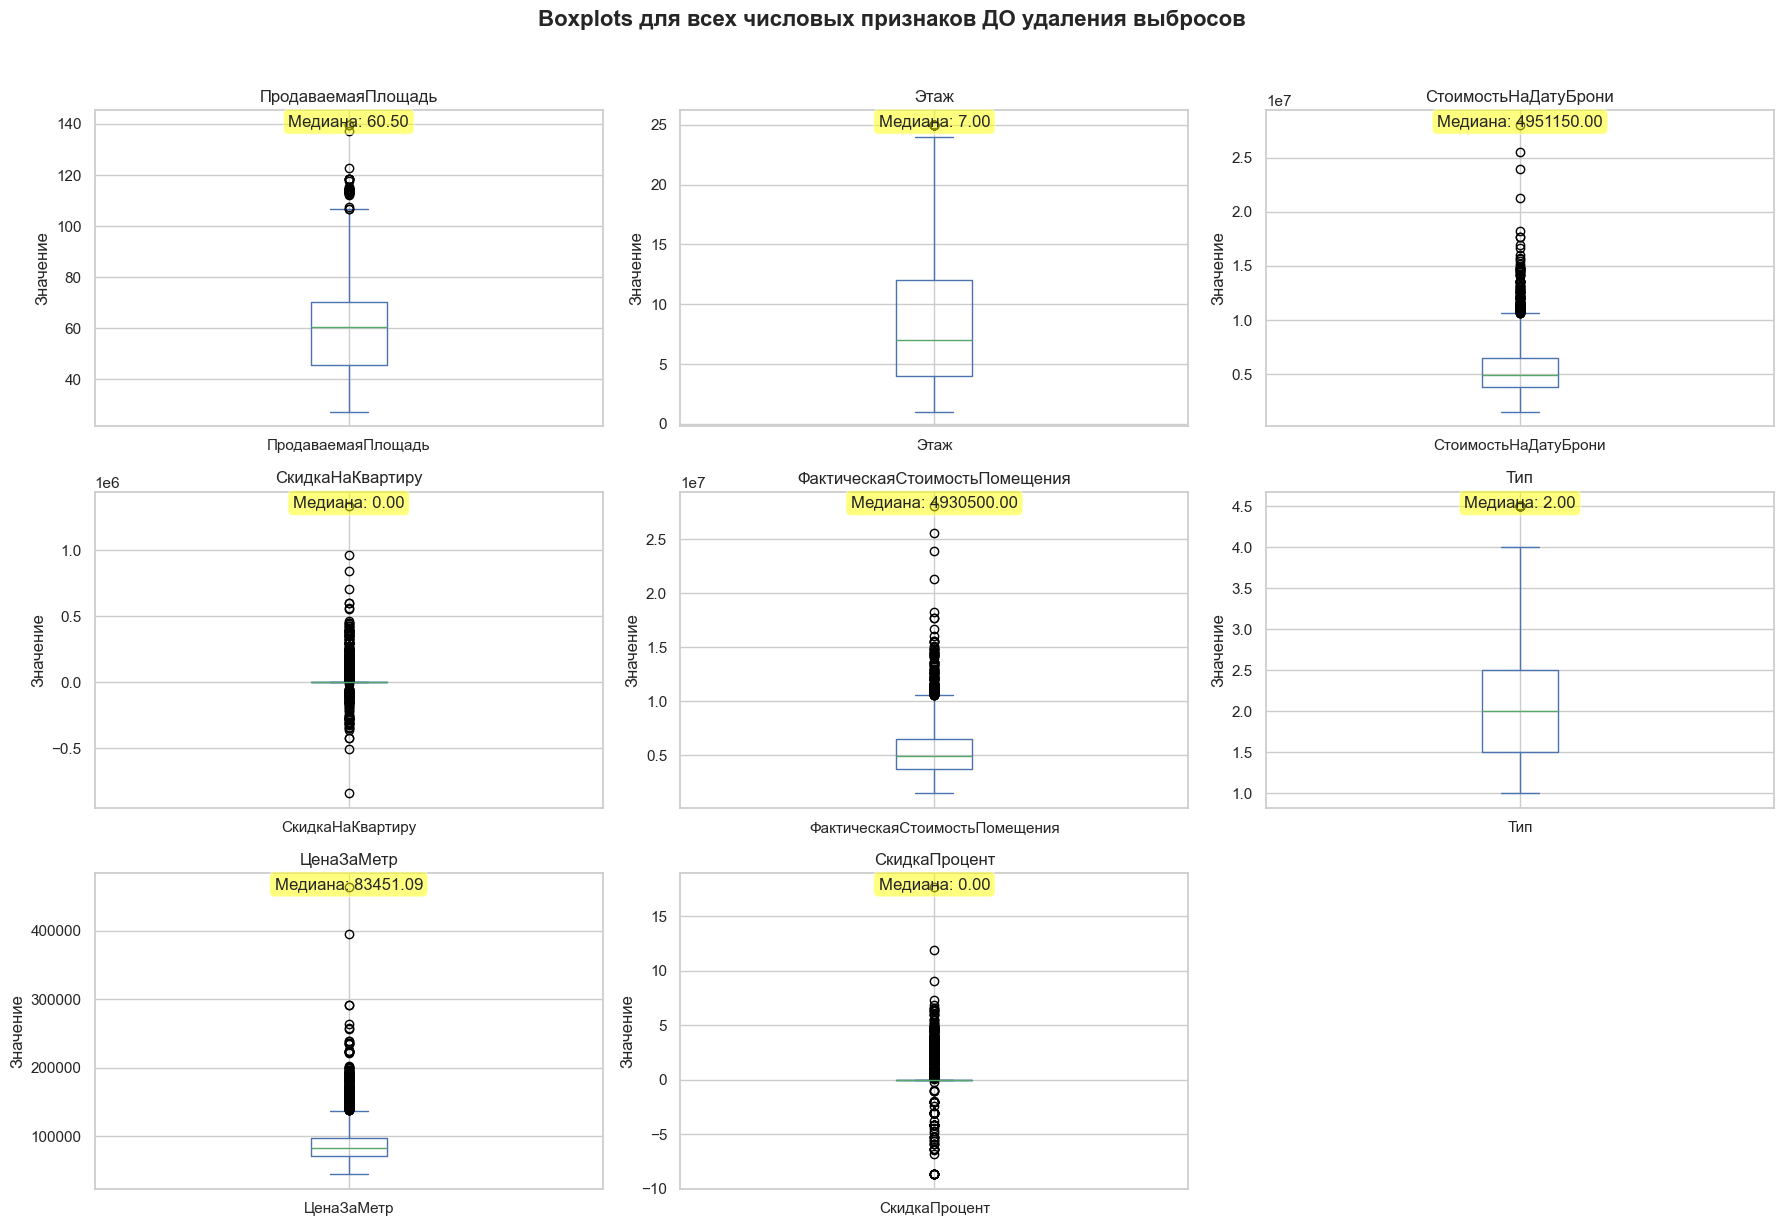


--- Статистика выбросов по каждому признаку ---
ПродаваемаяПлощадь                  | Выбросов:   50 (  1.3%) | Границы: [      9.26,     106.70]
Этаж                                | Выбросов:   26 (  0.7%) | Границы: [     -8.00,      24.00]
СтоимостьНаДатуБрони                | Выбросов:  138 (  3.5%) | Границы: [-357912.50, 10653787.50]
СкидкаНаКвартиру                    | Выбросов:  698 ( 17.7%) | Границы: [      0.00,       0.00]
ФактическаяСтоимостьПомещения       | Выбросов:  142 (  3.6%) | Границы: [-335937.50, 10608962.50]
Тип                                 | Выбросов:   28 (  0.7%) | Границы: [      0.00,       4.00]
ЦенаЗаМетр                          | Выбросов:  225 (  5.7%) | Границы: [  31553.34,  137964.52]
СкидкаПроцент                       | Выбросов:  698 ( 17.7%) | Границы: [      0.00,       0.00]


In [1826]:
print("--- Визуализация выбросов до удаления ---")
print(f"Медиана стоимости бронирования: {df_processed['СтоимостьНаДатуБрони'].median():,.0f} руб.")

# Все числовые признаки для анализа
numeric_features_for_boxplot = [
    'ПродаваемаяПлощадь', 
    'Этаж', 
    'СтоимостьНаДатуБрони', 
    'СкидкаНаКвартиру',
    'ФактическаяСтоимостьПомещения', 
    'Тип',
    'ЦенаЗаМетр', 
    'СкидкаПроцент'
]

# Создаем boxplot для всех числовых признаков
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_features_for_boxplot):
    if i < len(axes):
        ax = axes[i]
        df_processed[feature].plot(kind='box', ax=ax)
        ax.set_title(f'{feature}', fontsize=12)
        ax.set_ylabel('Значение')
        
        # Добавляем аннотации с медианой
        median_val = df_processed[feature].median()
        ax.text(0.5, 0.95, f'Медиана: {median_val:.2f}', 
                transform=ax.transAxes, ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

# Убираем лишние subplots
for i in range(len(numeric_features_for_boxplot), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Boxplots для всех числовых признаков ДО удаления выбросов", 
             y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Статистика по выбросам для каждого признака
print("\n--- Статистика выбросов по каждому признаку ---")
print("="*70)

for feature in numeric_features_for_boxplot:
    Q1 = df_processed[feature].quantile(0.25)
    Q3 = df_processed[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_processed[(df_processed[feature] < lower_bound) | (df_processed[feature] > upper_bound)]
    outlier_percentage = len(outliers) / len(df_processed) * 100
    
    print(f"{feature:35} | Выбросов: {len(outliers):4d} ({outlier_percentage:5.1f}%) | "
          f"Границы: [{lower_bound:10.2f}, {upper_bound:10.2f}]")

In [1827]:
print("\n" + "="*70)
print("--- Процесс удаления выбросов ---")
print("="*70)

df_original = df_processed.copy()
original_size = df_original.shape[0]

features_to_filter = [
    'ФактическаяСтоимостьПомещения',
    'ПродаваемаяПлощадь',
    'ЦенаЗаМетр',
    'СтоимостьНаДатуБрони'
]

df_filtered = df_original.copy()

for feature in features_to_filter:
    Q1 = df_filtered[feature].quantile(0.25)
    Q3 = df_filtered[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR
    
    outliers_before = df_filtered[(df_filtered[feature] < lower_bound) | (df_filtered[feature] > upper_bound)]
    
    df_filtered = df_filtered[(df_filtered[feature] >= lower_bound) & (df_filtered[feature] <= upper_bound)]
    
    print(f"{feature:35} | Удалено: {len(outliers_before):4d} строк "
          f"({len(outliers_before)/original_size*100:5.1f}%)")

print(f"\nИсходный размер датасета: {original_size} строк")
print(f"Размер после удаления выбросов: {df_filtered.shape[0]} строк")
print(f"Всего удалено: {original_size - df_filtered.shape[0]} строк "
      f"({(original_size - df_filtered.shape[0])/original_size*100:.1f}% данных)")

print("\n--- Анализ распределения целевого признака ---")
print(f"{'':20} | {'Исходно':>10} | {'После фильтрации':>10} | {'Потеряно':>10}")
print("-" * 70)

for target_value, label in [(0, 'Свободна (0)'), (1, 'Продана (1)')]:
    original_count = (df_original['target'] == target_value).sum()
    filtered_count = (df_filtered['target'] == target_value).sum()
    lost_count = original_count - filtered_count
    lost_percentage = lost_count / original_count * 100
    
    print(f"{label:20} | {original_count:10d} | {filtered_count:10d} | "
          f"{lost_count:10d} ({lost_percentage:5.1f}%)")


--- Процесс удаления выбросов ---
ФактическаяСтоимостьПомещения       | Удалено:   40 строк (  1.0%)
ПродаваемаяПлощадь                  | Удалено:    0 строк (  0.0%)
ЦенаЗаМетр                          | Удалено:  113 строк (  2.9%)
СтоимостьНаДатуБрони                | Удалено:    8 строк (  0.2%)

Исходный размер датасета: 3944 строк
Размер после удаления выбросов: 3783 строк
Всего удалено: 161 строк (4.1% данных)

--- Анализ распределения целевого признака ---
                     |    Исходно | После фильтрации |   Потеряно
----------------------------------------------------------------------
Свободна (0)         |       2804 |       2690 |        114 (  4.1%)
Продана (1)          |       1140 |       1093 |         47 (  4.1%)



--- Визуализация выбросов ПОСЛЕ удаления ---


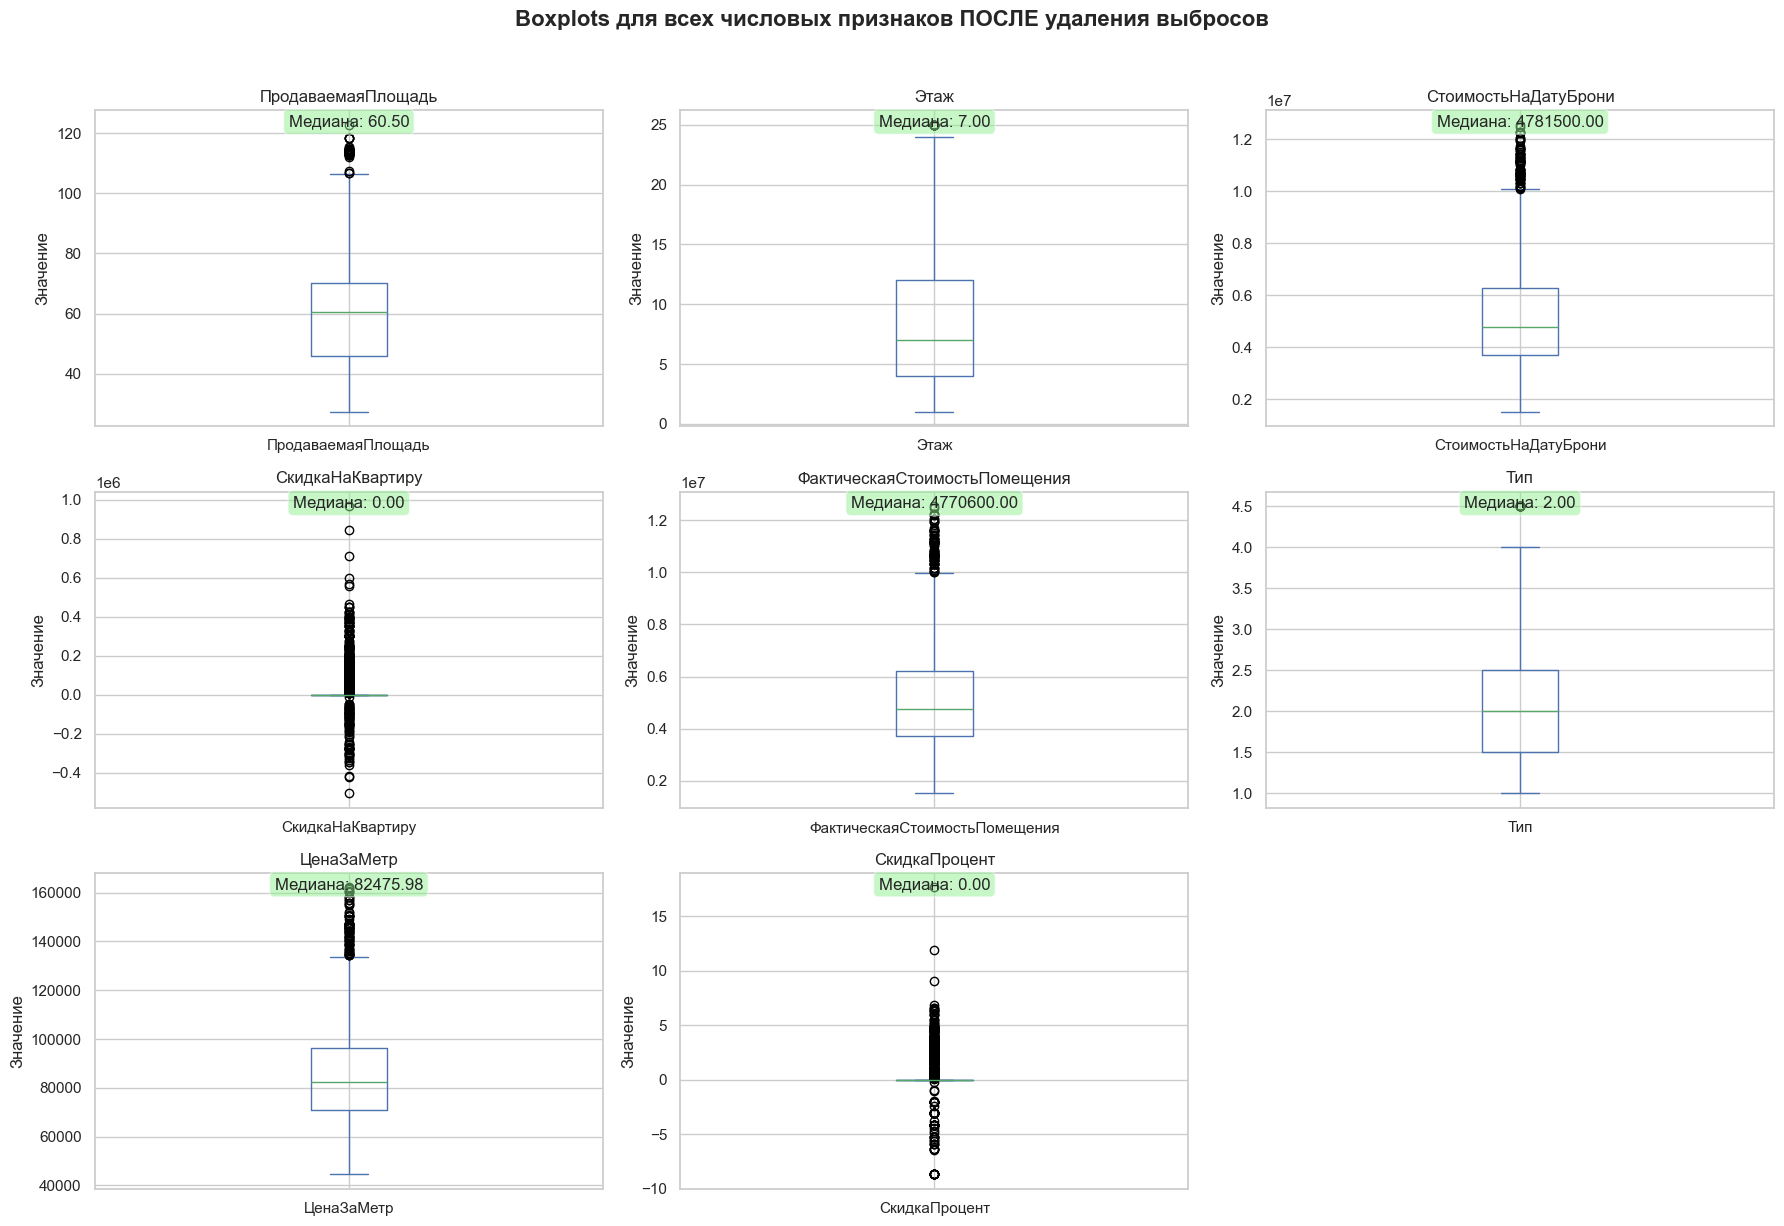

In [1828]:
print("\n" + "="*70)
print("--- Визуализация выбросов ПОСЛЕ удаления ---")
print("="*70)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_features_for_boxplot):
    if i < len(axes):
        ax = axes[i]
        df_filtered[feature].plot(kind='box', ax=ax)
        ax.set_title(f'{feature}', fontsize=12)
        ax.set_ylabel('Значение')
        
        median_val = df_filtered[feature].median()
        ax.text(0.5, 0.95, f'Медиана: {median_val:.2f}', 
                transform=ax.transAxes, ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.5))

for i in range(len(numeric_features_for_boxplot), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Boxplots для всех числовых признаков ПОСЛЕ удаления выбросов", 
             y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

переобучение моделей

In [1829]:
df_filtered['СкидкаНаКвартиру'] = np.where(df_filtered['СкидкаНаКвартиру'] > 0, 0.5, -0.5)

y = df_filtered['target']
X = df_filtered.drop('target', axis=1)

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled['СкидкаНаКвартиру'] = np.where(df_filtered['СкидкаНаКвартиру'] > 0, 0.5, -0.5)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=1000000000, stratify=y
)
print(f"Данные готовы. Train: {X_train.shape}, Test: {X_test.shape}")

knn_no_outliers = KNeighborsClassifier()
knn_no_outliers_results = evaluate_model(knn_no_outliers, "K-Nearest Neighbors (KNN) no_outliers")

tree_no_outliers = DecisionTreeClassifier(random_state=42)
tree_no_outliers_results = evaluate_model(tree_no_outliers, "Decision Tree no_outliers ")



Данные готовы. Train: (2648, 25), Test: (1135, 25)

--- Оценка модели: K-Nearest Neighbors (KNN) no_outliers ---
  Обучающая выборка: Precision=0.8845, Recall=0.8105, F1=0.8458
  Тестовая выборка:  Precision=0.8211, Recall=0.7835, F1=0.8019

--- Оценка модели: Decision Tree no_outliers  ---
  Обучающая выборка: Precision=1.0000, Recall=0.9882, F1=0.9941
  Тестовая выборка:  Precision=0.7456, Recall=0.7774, F1=0.7612


--- Подбор оптимального k для KNN ---


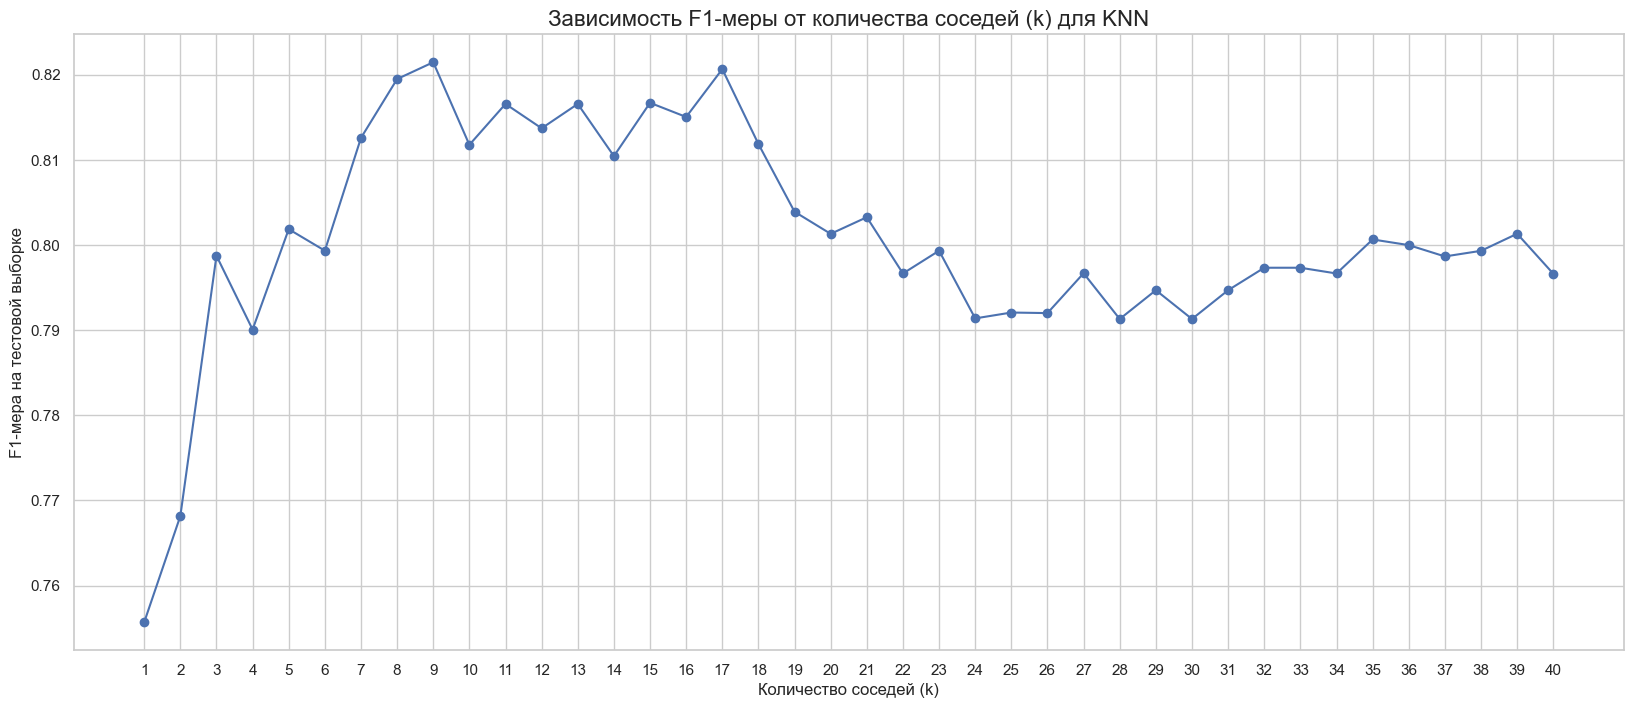

Оптимальное значение k для KNN: 9 (F1-мера: 0.8215)

--- Подбор оптимальной глубины для Decision Tree ---


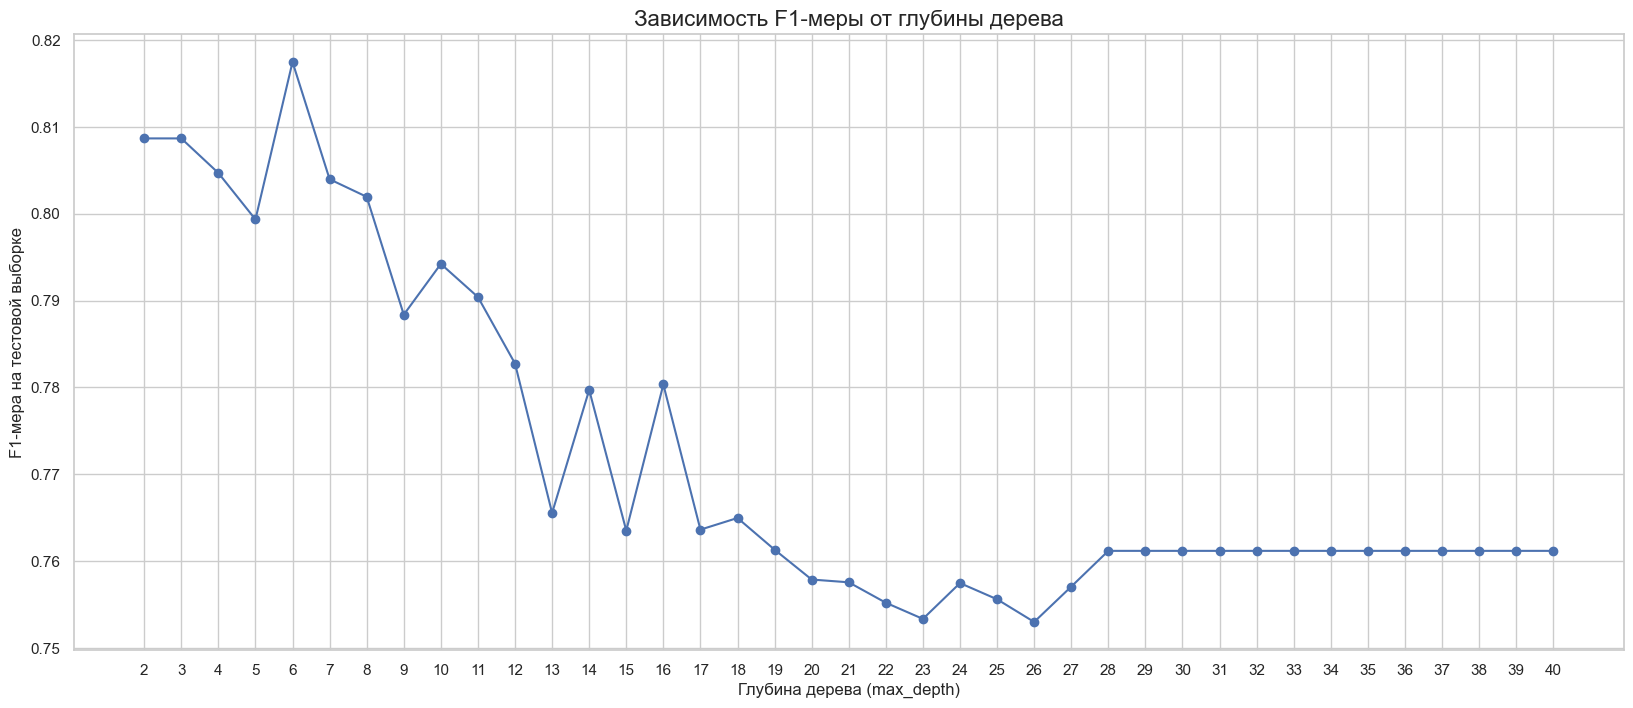

Оптимальное значение max_depth для Decision Tree: 6 (F1-мера: 0.8174)


In [1830]:

print("--- Подбор оптимального k для KNN ---")
k_range = range(1, 41)
f1_scores_knn = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores_knn.append(f1_score(y_test, y_pred))


plt.figure(figsize=(20, 8))
plt.plot(k_range, f1_scores_knn, marker='o')
plt.title('Зависимость F1-меры от количества соседей (k) для KNN', fontsize=16)
plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('F1-мера на тестовой выборке', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()


optimal_k = k_range[np.argmax(f1_scores_knn)]
print(f"Оптимальное значение k для KNN: {optimal_k} (F1-мера: {max(f1_scores_knn):.4f})")


print("\n--- Подбор оптимальной глубины для Decision Tree ---")
depth_range = range(2, 41)
f1_scores_tree = []

for depth in depth_range:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    f1_scores_tree.append(f1_score(y_test, y_pred))


plt.figure(figsize=(20, 8))
plt.plot(depth_range, f1_scores_tree, marker='o')
plt.title('Зависимость F1-меры от глубины дерева', fontsize=16)
plt.xlabel('Глубина дерева (max_depth)', fontsize=12)
plt.ylabel('F1-мера на тестовой выборке', fontsize=12)
plt.xticks(depth_range)
plt.grid(True)
plt.show()


optimal_depth = depth_range[np.argmax(f1_scores_tree)]
print(f"Оптимальное значение max_depth для Decision Tree: {optimal_depth} (F1-мера: {max(f1_scores_tree):.4f})")

### 17 Логистическая регрессии (LogisticRegression).

In [1831]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


log_reg = LogisticRegression(max_iter=2000, random_state=42)
log_reg_results = evaluate_model(log_reg, "Logistic Regression")



--- Оценка модели: Logistic Regression ---
  Обучающая выборка: Precision=0.8992, Recall=0.7582, F1=0.8227
  Тестовая выборка:  Precision=0.8842, Recall=0.7683, F1=0.8222


### 18 Алгоритм SVM (машины опорных векторов) (LinearSVC).

In [1832]:
svm = LinearSVC(max_iter=5000, random_state=42, dual=False)
svm_results = evaluate_model(svm, "SVM (LinearSVC)")


--- Оценка модели: SVM (LinearSVC) ---
  Обучающая выборка: Precision=0.8968, Recall=0.7608, F1=0.8232
  Тестовая выборка:  Precision=0.8850, Recall=0.7744, F1=0.8260


In [1833]:

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal_results = evaluate_model(knn_optimal, "KNN (Optimal k)")

tree_optimal = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
tree_optimal_results = evaluate_model(tree_optimal, "Decision Tree (Optimal depth)")



all_results = pd.DataFrame([
    knn_results,
    tree_results,
    knn_no_outliers_results,
    tree_no_outliers_results,
    knn_optimal_results,
    tree_optimal_results,
    log_reg_results,
    svm_results
])


all_results_sorted = all_results.sort_values('test_f1', ascending=False).reset_index(drop=True)

display(all_results_sorted)



--- Оценка модели: KNN (Optimal k) ---
  Обучающая выборка: Precision=0.8797, Recall=0.7935, F1=0.8344
  Тестовая выборка:  Precision=0.8525, Recall=0.7927, F1=0.8215

--- Оценка модели: Decision Tree (Optimal depth) ---
  Обучающая выборка: Precision=0.8988, Recall=0.7895, F1=0.8406
  Тестовая выборка:  Precision=0.8694, Recall=0.7713, F1=0.8174


,model,train_precision,train_recall,train_f1,test_precision,test_recall,test_f1
0,SVM (LinearSVC),0.896764,0.760784,0.823197,0.885017,0.774390,0.826016
1,Logistic Regression,0.899225,0.758170,0.822695,0.884211,0.768293,0.822186
2,KNN (Optimal k),0.879710,0.793464,0.834364,0.852459,0.792683,0.821485
3,Decision Tree (Optimal depth),0.898810,0.789542,0.840640,0.869416,0.771341,0.817447
4,K-Nearest Neighbors (KNN) no_outliers,0.884451,0.810458,0.845839,0.821086,0.783537,0.801872
5,Decision Tree,1.000000,0.982456,0.991150,0.809668,0.783626,0.796434
6,Decision Tree no_outliers,1.000000,0.988235,0.994083,0.745614,0.777439,0.761194
7,K-Nearest Neighbors (KNN),0.853994,0.776942,0.813648,0.763699,0.652047,0.703470
